<a href="https://colab.research.google.com/github/geraldoferreira1963/Analise_Sentimento/blob/main/Analise_Sentimento_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O objetivo do trabalho é utilizando um dataset (https://www.kaggle.com/datasets/deepakjoshi2k/yahoo-stock-prediction-by-news) predizer se ação de uma dada empresa - no final de dia de negociação - subirá ou descera (tomando como base o dia anterior).


Este algoritmo, juntamente com outros algoritmos ou metodologias, por exemplo Análise Gráfica, poderiam ser combinados a fim de se criar um ferramenta de suporte a operação de compra e venda de ativos em um único dia na bolsa de valores.


No treinamento do algoritmo foi utilizado o dataset https://www.kaggle.com/datasets/deepakjoshi2k/yahoo-stock-prediction-by-news, o qual possui as seguintes colunas :   

(i)     **ticker** : código da ação na Bolsa de Valores de New York
(ii)    **Date** : Data da notícia ou opinião
(iii)   **Category** : se é uma notícia, ou uma opinião de um analista.
(iv)    **title** : título da notícia, ou do artigo
(v)     **content** : conteúdo da notícia, ou do artigo
(vi)    **Open** : valor de abertura da ação
(vii)   **High** : valor de fechamento da ação
(viii)  **Low** : menor valor da ação no dia
(ix)    **Close** : valor de fechamento do preço da ação
(x)     **Adj cloe** : Ajusted Closing Price, ajuste no preço da ação decorrente de algum evento na base acionária da empresa
(xi)    **Volume** : volume de ações negociadas no dia
(xii) **label** : indicação se o preço da ação fechou com um valor maior que o preço **inicial** (1), ou fechou em um valor menor (0)





In [57]:
!pip install scikit-learn -q
!pip install transformers -q
!pip install gensim -q




import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import time
import pickle
import warnings


from gensim.models import Word2Vec
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython import get_ipython
from IPython.display import display,HTML
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, TFBertModel
from sklearn.exceptions import ConvergenceWarning

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

warnings.filterwarnings("ignore", category=DataConversionWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


As funções abaixo foram criadas.

(1) dataframe_analize : objetivo é realizar uma simples
(2) b

In [58]:
def analisar_dataframe (df, column_name='title'):  # Add column_name parameter with default 'title'
    """Analyzes a DataFrame and prints statistics about labels, content, and category.

    Args:
        df: The DataFrame to analyze.
        column_name: The column to use for content analysis ('title' or 'content').
    """

    # Count and print label occurrences
    label_counts = df['label'].value_counts()
    print("Número de Linhas com Label 0:", label_counts[0])
    print("Número de Linhas com Label 1:", label_counts[1])

    # Plot label distribution
    label_counts.plot(kind='bar', title='Distribuição dos Labels')
    plt.xlabel('Label')
    plt.ylabel('Contagem')
    plt.show()

    # Calculate and print content length statistics
    df['text_length'] = df[column_name].apply(len)  # Use column_name instead of 'title'
    print("\n\n","Minimo comprimento do conteúdo:", df['text_length'].min())  # Use 'text_length'
    print("\n\n","Máximo comprimento do conteúdo:", df['text_length'].max())  # Use 'text_length'

    # Calculate and print the number of unique words
    all_words = ' '.join(df[column_name]).lower().split()  # Use column_name instead of 'title'
    unique_words = set(all_words)
    print("\n\n","Numero de palavras únicas:", len(unique_words))

    # Combined category-label plot
    plt.figure(figsize=(12, 6))
    sns.countplot(x='category', hue='label', data=df)
    plt.title('Distribuição das Categorias/Label')
    plt.xlabel('Categoria')
    plt.ylabel('Contagem')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return(len(unique_words),df['text_length'].min(),df['text_length'].max())

In [59]:
def criar_dataframe_balanceado(df, num_instances):
  """Creates a balanced DataFrame with a specified number of instances for each label.

  Args:
    df: The original DataFrame.
    num_instances: The desired number of instances for each label.

  Returns:
    A new DataFrame with balanced labels.
  """

  # Separate instances with label 0 and label 1
  label_0_df = df[df['label'] == 0]
  label_1_df = df[df['label'] == 1]

  # Sample the desired number of instances from each label
  balanced_label_0_df = label_0_df.sample(n=num_instances, random_state=42)  # Use random_state for reproducibility
  balanced_label_1_df = label_1_df.sample(n=num_instances, random_state=42)

  # Concatenate the balanced DataFrames
  balanced_df = pd.concat([balanced_label_0_df, balanced_label_1_df])

  return balanced_df

In [60]:
def preprocess_text(text, lemmatize=True):
    """Removes stop words, punctuation, and optionally performs lemmatization.

    Args:
        text: The input text string.
        lemmatize: A boolean indicating whether to perform lemmatization.

    Returns:
        The preprocessed text string.
    """

    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize if specified
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [61]:
def treino (pipeline_name, pipeline, param_grid, X_train, y_train):
    """
    Trains a pipeline using GridSearchCV and measures the training time.

    Args:
        pipeline_name (str): The name of the pipeline (e.g., 'Logistic Regression').
        pipeline: The pipeline object to be trained.
        param_grid (dict): The parameter grid for GridSearchCV.
        X_train: The training data.
        y_train: The training labels.

    Returns:
        float: The training time in seconds.
    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
    start_time = time.time()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        grid_search.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{pipeline_name} training time: {training_time:.2f} seconds")
    return training_time, grid_search.best_estimator_, grid_search


In [62]:
def plot_acuracia_por_max_features(logreg_grid_search, svm_grid_search):
    """Plots accuracy against the number of features/tokens for Logistic Regression and SVM.

    Args:
        logreg_grid_search: The Logistic Regression GridSearchCV object.
        svm_grid_search: The SVM GridSearchCV object.
    """

    # Check if 'param_preprocessor__tfidf__max_features' is in cv_results_
    if 'param_preprocessor__tfidf__max_features' in logreg_grid_search.cv_results_:
        logreg_results = pd.DataFrame(logreg_grid_search.cv_results_)
        logreg_accuracy_by_max_features = logreg_results.groupby('param_preprocessor__tfidf__max_features')['mean_test_score'].mean()
    else:
        # If not present, assume a single value (e.g., the vector_size in Doc2Vec)
        logreg_accuracy_by_max_features = pd.Series(logreg_grid_search.best_score_, index=[100])  # Assuming vector_size = 100

    # Similar check for SVM
    if 'param_preprocessor__tfidf__max_features' in svm_grid_search.cv_results_:
        svm_results = pd.DataFrame(svm_grid_search.cv_results_)
        svm_accuracy_by_max_features = svm_results.groupby('param_preprocessor__tfidf__max_features')['mean_test_score'].mean()
    else:
        svm_accuracy_by_max_features = pd.Series(svm_grid_search.best_score_, index=[100])

    plt.figure(figsize=(10, 6))
    plt.plot(logreg_accuracy_by_max_features.index, logreg_accuracy_by_max_features.values, marker='o', label='Logistic Regression')
    plt.plot(svm_accuracy_by_max_features.index, svm_accuracy_by_max_features.values, marker='x', label='SVM')
    plt.title('Acurácia por # Features/Tokens')
    plt.xlabel('# Features/Tokens')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)
    plt.show()

In [63]:
def avaliacao_e_plot_acuracia(y_test, logreg_bert_predictions, svm_bert_predictions):
    """Evaluates and reports the accuracy of Logistic Regression and SVM models.

    Args:
        y_test: The true labels for the test data.
        logreg_bert_predictions: The predictions from the Logistic Regression model.
        svm_bert_predictions: The predictions from the SVM model.
    """

    # Logistic Regression Evaluation
    logreg_bert_accuracy = accuracy_score(y_test, logreg_bert_predictions)
    print(f"Acurácia Logistic Regression (após otimização): {logreg_bert_accuracy}")
    print(classification_report(y_test, logreg_bert_predictions))

    # SVM Evaluation
    svm_bert_accuracy = accuracy_score(y_test, svm_bert_predictions)
    print("\n\n",f"Acurácia SVM Accuracy (após otimização): {svm_bert_accuracy}")
    print(classification_report(y_test, svm_bert_predictions))

In [64]:
def impressao_tempo(training_time_seconds, model_name):
    """Prints the training time in hours, minutes, and seconds.

    Args:
        training_time_seconds: The training time in seconds.
        model_name: The name of the model being trained.
    """

    hours = int(training_time_seconds // 3600)
    minutes = int((training_time_seconds % 3600) // 60)
    seconds = int(training_time_seconds % 60)

    print("\n\n",f"Tempo de Treinamento - {model_name}: {hours:02d}:{minutes:02d}:{seconds:02d}")

In [65]:
def display_best_hyperparameters(grid_search, model_name):
    """Displays the best hyperparameters and their scores in a table format.

    Args:
        grid_search_results: The cv_results_ attribute of the GridSearchCV object.
        model_name: The name of the model.
    """

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    table_html = f"<h3>{model_name} - Melhores Parametros e Score </h3>"
    table_html += "<table><tr><th>Hyperparameter</th><th>Value</th></tr>"
    for param, value in best_params.items():
        table_html += f"<tr><td>{param}</td><td>{value}</td></tr>"
    table_html += f"<tr><td><b>Best Score</b></td><td><b>{best_score:.4f}</b></td></tr></table>"

    display(HTML(table_html))


In [66]:
def plot_confusion_matrices(y_test, logreg_predictions, svm_predictions):
    """Plots confusion matrices for Logistic Regression and SVM models.

    Args:
        y_test: The true labels for the test data.
        logreg_predictions: The predictions from the Logistic Regression model.
        svm_predictions: The predictions from the SVM model.
    """

    # Calculate confusion matrices
    logreg_cm = confusion_matrix(y_test, logreg_predictions)
    svm_cm = confusion_matrix(y_test, svm_predictions)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Logistic Regression confusion matrix
    sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Matrix Confusão - Regressão Logística')
    axes[0].set_xlabel('Predição')
    axes[0].set_ylabel('Real')

    # Plot SVM confusion matrix
    sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title('Matrix Confusão - SVM')  # Changed title to SVM
    axes[1].set_xlabel('Predição')
    axes[1].set_ylabel('Real')

    plt.show()  # Add plt.show() to display the plot

Gerar BERT embeddings

In [67]:
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
    outputs = model(inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token embedding
    return embeddings.numpy()



In [68]:
def acuracia_por_categoria(y_true, y_pred, categories):
    """Calculates and prints accuracy for each category.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.
        categories: Category values corresponding to the data points.
    """

    unique_categories = np.unique(categories)
    for category in unique_categories:
        category_indices = np.where(categories == category)[0]
        y_true_category = y_true[category_indices]
        y_pred_category = y_pred[category_indices]

        # Calculate accuracy for the category
        accuracy = accuracy_score(y_true_category, y_pred_category)
        print(f"Accuracy for category '{category}': {accuracy:.2f}")

In [69]:
# Corrected URL to download the raw Excel file from GitHub
url = 'https://raw.githubusercontent.com/geraldoferreira1963/Analise_Sentimento/main/carga_inicial_6.xlsx'

response = requests.get(url)

# Save the content to a file with .xlsx extension
with open('carga_inicial_6.xlsx', 'wb') as file:
    file.write(response.content)

# Read the Excel file, explicitly specifying the engine
df = pd.read_excel('carga_inicial_6.xlsx', engine='openpyxl') # Added engine parameter

# Display the first few rows of the DataFrame
df.head()

,Date,category,title,content,label
0,2020-01-27,opinion,Apple Set To Beat Q1 Earnings Estimates Tech ...,Technology giant Apple NASDAQ AAPL is set ...,0
1,2020-01-27,opinion,Tech Daily Intel Results Netflix Surge Appl...,The top stories in this digest are Intel s N...,0
2,2020-01-27,opinion,7 Monster Stock Market Predictions For The Wee...,S P 500 SPY \nThis week will be packed with e...,0
3,2020-01-27,opinion,Apple Earnings Preview 5G Launch Expanding S...,Reports Q1 2020 results on Tuesday Jan 28 ...,0
4,2020-01-27,opinion,Buy Surging Apple Microsoft Stock Before Qua...,On today s episode of Full Court Finance here ...,0


Visualização Inicial do Dataset

Número de Linhas com Label 0: 7135
Número de Linhas com Label 1: 8840


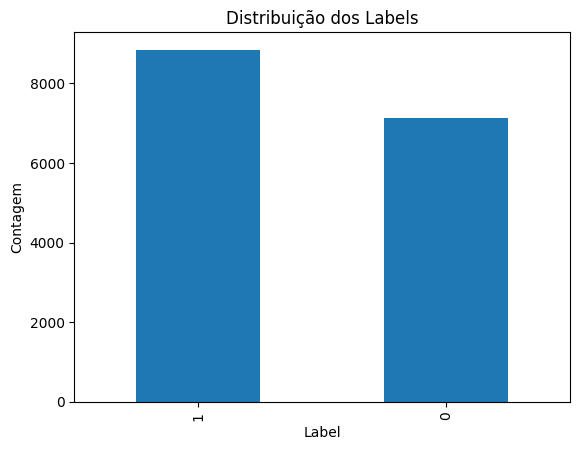



 Minimo comprimento do conteúdo: 41


 Máximo comprimento do conteúdo: 32765


 Numero de palavras únicas: 85086


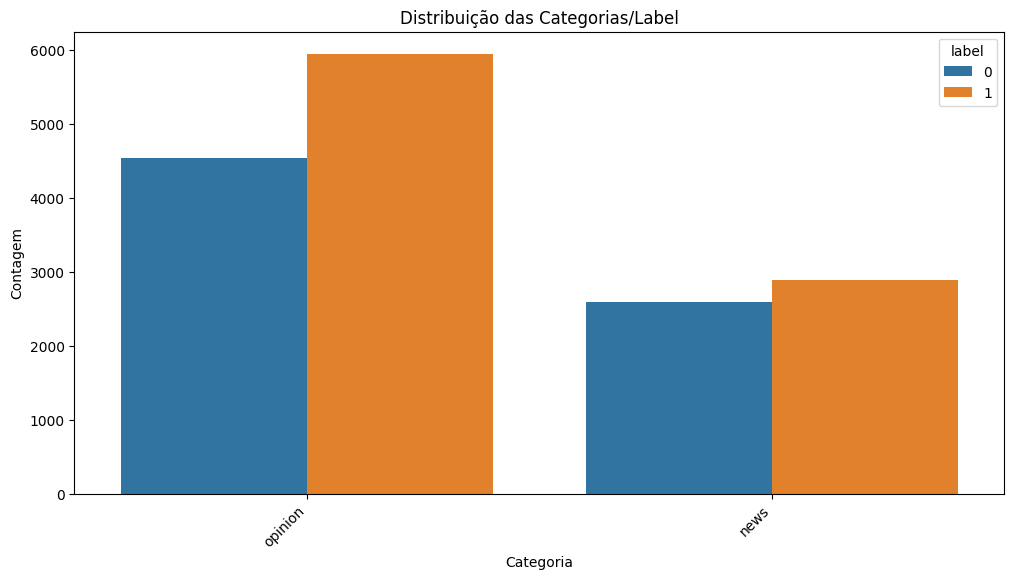

(85086, 41, 32765)

In [70]:

# Verificação Inicial do dataset
analisar_dataframe(df,column_name='content')  # Call the function to analyze your DataFrame


Ajuste Inicial

Número de Linhas com Label 0: 100
Número de Linhas com Label 1: 100


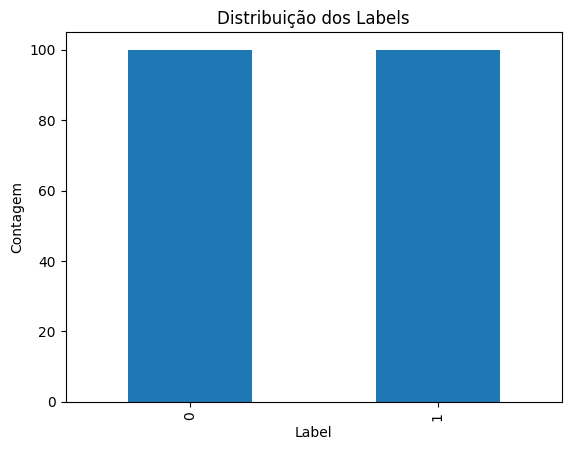



 Minimo comprimento do conteúdo: 67


 Máximo comprimento do conteúdo: 13304


 Numero de palavras únicas: 10182


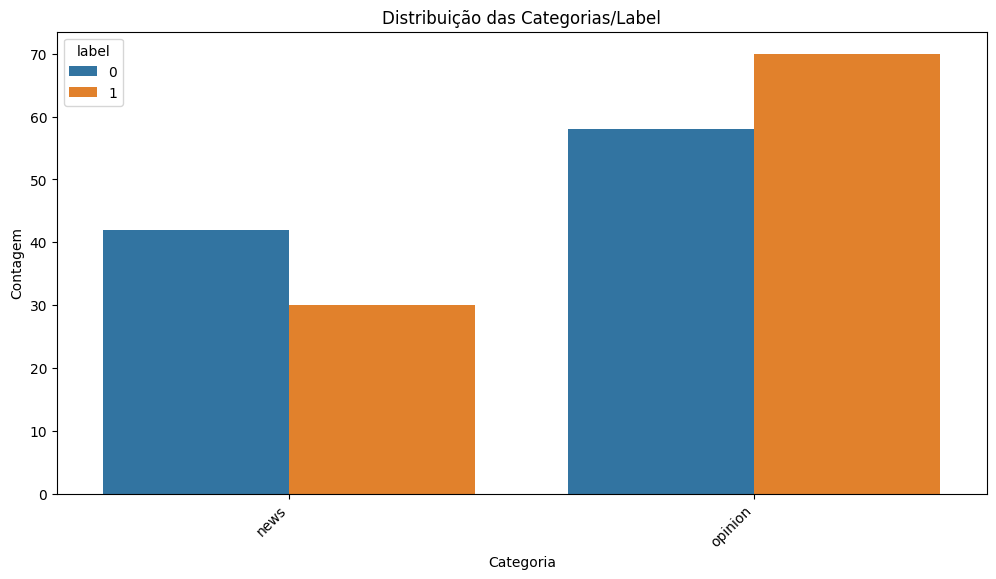

In [71]:
# Example usage:
num_instances_per_label = 100  # Definir o número de instancias
balanced_df = criar_dataframe_balanceado(df, num_instances_per_label)
max_tokens,min_cont,max_cont = analisar_dataframe(balanced_df,column_name='content')

Preparação dos Dados

(1) Coluna News ou Opiniao
(2) Coluna Categoria
(3) Coluna label


In [72]:
print("Número de palavras únicas:", max_tokens)
print("Minimo comprimento do conteúdo:", min_cont)
print("Máximo comprimento do conteúdo:", max_cont)

Número de palavras únicas: 10182
Minimo comprimento do conteúdo: 67
Máximo comprimento do conteúdo: 13304


# TD-IDF



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Logistic Regression training time: 61.83 seconds
Fitting 5 folds for each of 36 candidates, totalling 180 fits
SVM training time: 26.62 seconds
Acurácia Logistic Regression (após otimização): 0.6
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        21
           1       0.57      0.68      0.62        19

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.60        40
weighted avg       0.61      0.60      0.60        40



 Acurácia SVM Accuracy (após otimização): 0.575
              precision    recall  f1-score   support

           0       0.61      0.52      0.56        21
           1       0.55      0.63      0.59        19

    accuracy                           0.57        40
   macro avg       0.58      0.58      0.57        40
weighted avg       0.58      0.57      0.57        40



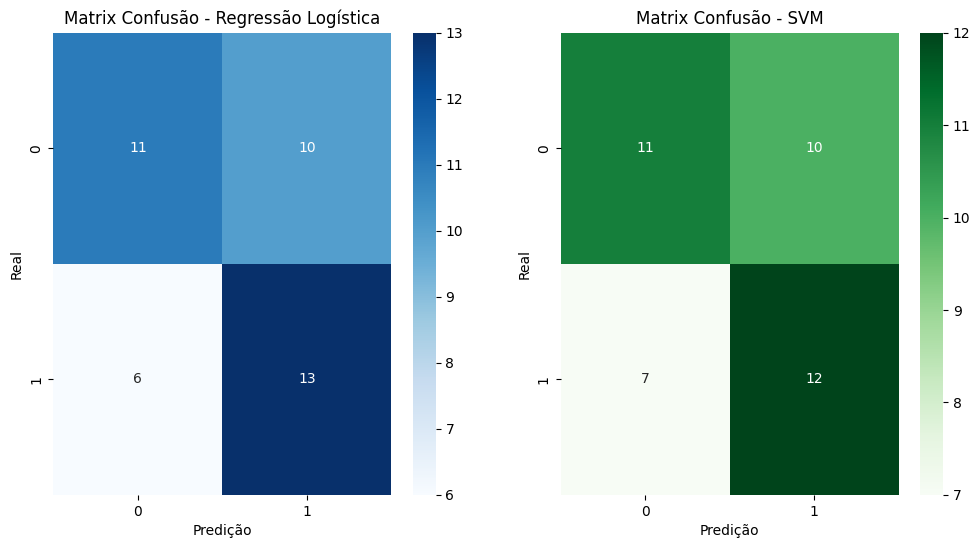

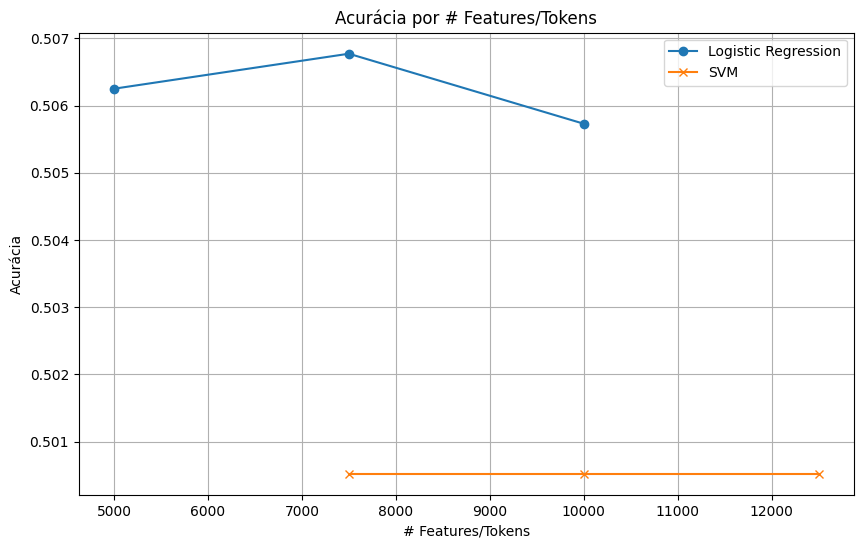

Hyperparameter,Value
logreg__C,0.1
logreg__penalty,l2
logreg__solver,liblinear
preprocessor__tfidf__max_features,5000
Best Score,0.5500


Hyperparameter,Value
preprocessor__tfidf__max_features,7500
svm__C,1
svm__gamma,scale
svm__kernel,rbf
Best Score,0.5563




 Tempo de Treinamento - Regressão Logística: 00:01:01


 Tempo de Treinamento - SVM: 00:00:26
Accuracy for category 'news': 0.65
Accuracy for category 'opinion': 0.57
Accuracy for category 'news': 0.65
Accuracy for category 'opinion': 0.52


In [73]:
#####  Pré Preparação dos Dados ################################################

# Remoção de Features

balanced_df['content'] = balanced_df['content'].apply(preprocess_text)

### Vetorização da coluna content e label encode da coluna categoria

def label_encode(X):
    le = LabelEncoder()
    encoded = le.fit_transform(X.values.ravel())
    return le.fit_transform(X).reshape(-1, 1)  # Reshape to 2D

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=5000), 'content'),
        ('label_encoder', FunctionTransformer(label_encode, validate=False), ['category']),
    ],
    remainder='drop',  # Drop other columns
    verbose_feature_names_out=False

)

X = balanced_df[['content', 'category']]
y = balanced_df['label'].values.ravel()

######################### Criando os dados de Treinamento e Teste ##############

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Pipelines Regressão Logística e  SVM ####################################

pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=500)),
])

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVC()),
])

########## Hipeparametros ######################################################
# Regressão Logística
# max_features = Número de Tokens/Palavras a serem mantidas no Vetor TD-IDF om base na sua importância
# C = Controle da Regularização : Trade Off entre Bias X Variança e Complexidade do Modelo
# Penalty : L1 (lasso) e  L2 (ridge)
# Solver : Algoritmo a ser usado na otimização (LIBLINEAR ou SAGA). SAGA : Grande Dataset X LIBLINEAR : Otimizador Simples
# Kernel : linear :  Relações mais lineares X  RBF kernel: flexibilidade e relações não lineares.

logreg_param_grid = {
    'preprocessor__tfidf__max_features': [5000, 7500, 10000],
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga']
}

svm_param_grid = {
    'preprocessor__tfidf__max_features': [7500, 10000, 12500],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}


############################## Treinamento #####################################

# Regressão Logistica

logreg_training_time,logreg_best_model, logreg_grid_search= treino(
    'Logistic Regression', pipeline_logreg, logreg_param_grid, X_train, y_train
)

# SVM

svm_training_time,svm_best_model, svm_grid_search = treino(
    'SVM', pipeline_svm, svm_param_grid, X_train, y_train
)



############### Teste #########################################################

logreg_predictions = logreg_best_model.predict(X_test)
svm_predictions = svm_best_model.predict(X_test)


############## Resultado ######################################################

# Geral

avaliacao_e_plot_acuracia(y_test, logreg_predictions, svm_predictions)

# Matriz Confusão

plot_confusion_matrices(y_test, logreg_predictions, svm_predictions)

# Acurácia X Max Features
logreg_grid_search_results = logreg_grid_search.cv_results_
svm_grid_search_results = svm_grid_search.cv_results_
plot_acuracia_por_max_features(logreg_grid_search, svm_grid_search)


# Impressão Melhores Hipe-Parametros
display_best_hyperparameters(logreg_grid_search, "Regressão Logística")
display_best_hyperparameters(svm_grid_search, "SVM")


# Tempos de Treinamento

impressao_tempo(logreg_training_time, "Regressão Logística")
impressao_tempo(svm_training_time, "SVM")


# Verificando a acuracia por Categoria

X_test_categories = balanced_df.loc[X_test.index, 'category'].values

# Acurácia por Categoria - Regressão Logística
acuracia_por_categoria(y_test, logreg_predictions, X_test_categories)

# Acurácia por Categoria - SVM
acuracia_por_categoria(y_test, svm_predictions, X_test_categories)



# DOC2Vec

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Logistic Regression training time: 4.95 seconds
Fitting 5 folds for each of 18 candidates, totalling 90 fits
SVM training time: 0.74 seconds
Acurácia Logistic Regression (após otimização): 0.225
              precision    recall  f1-score   support

           0       0.25      0.24      0.24        21
           1       0.20      0.21      0.21        19

    accuracy                           0.23        40
   macro avg       0.23      0.22      0.22        40
weighted avg       0.23      0.23      0.23        40



 Acurácia SVM Accuracy (após otimização): 0.4
              precision    recall  f1-score   support

           0       0.29      0.10      0.14        21
           1       0.42      0.74      0.54        19

    accuracy                           0.40        40
   macro avg       0.35      0.42      0.34        40
weighted avg       0.35      0.40      0.33        40



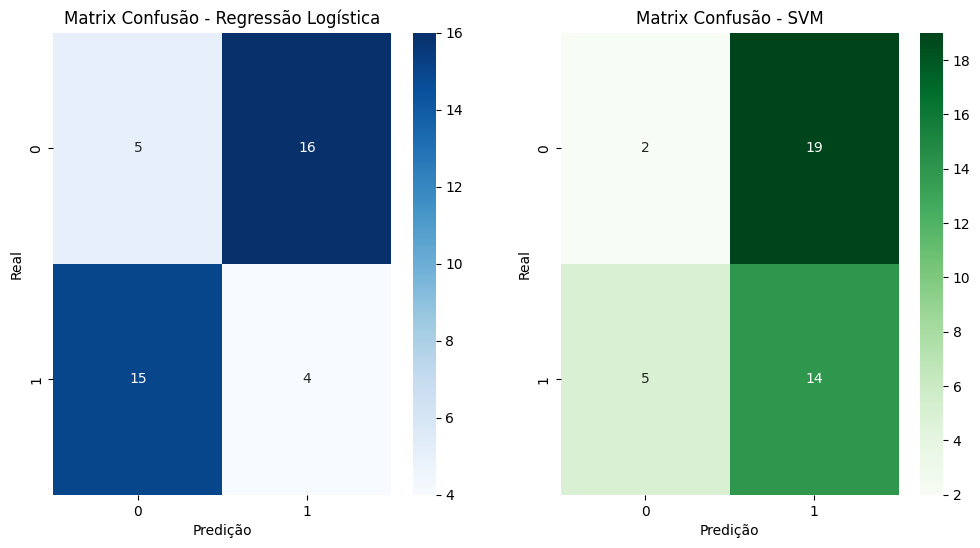

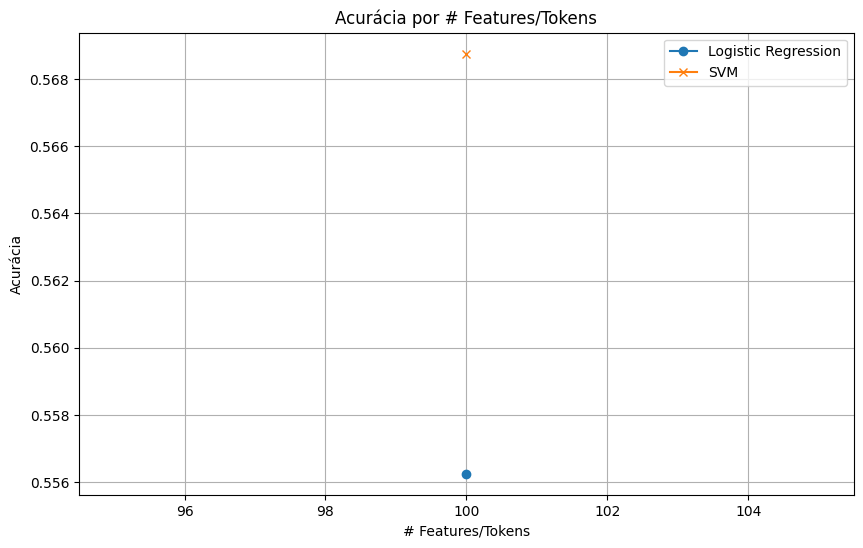

Hyperparameter,Value
logreg__C,1
logreg__penalty,l2
logreg__solver,saga
Best Score,0.5563


Hyperparameter,Value
svm__C,1
svm__gamma,auto
svm__kernel,poly
Best Score,0.5687




 Tempo de Treinamento - Regressão Logística: 00:00:04


 Tempo de Treinamento - SVM: 00:00:00
Accuracy for category 'news': 0.24
Accuracy for category 'opinion': 0.22
Accuracy for category 'news': 0.29
Accuracy for category 'opinion': 0.48


In [74]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#####  Pré Preparação dos Dados ################################################

# Remoção de Features

balanced_df['content'] = balanced_df['content'].apply(preprocess_text)

### Vetorização da coluna content e label encode da coluna categoria

# 1. Prepare data for Doc2Vec

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(balanced_df['content'].apply(lambda x: x.split()))]

# 2. Train Doc2Vec model
model_d2v = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=20)  # Adjust parameters as needed

# 3. Get document embeddings
X_d2v = [model_d2v.infer_vector(doc.words) for doc in documents]
X_d2v = np.array(X_d2v)

# 4. Label encode the 'category' column
label_encoder = LabelEncoder()
X_category_encoded = label_encoder.fit_transform(balanced_df['category'])
X_category_encoded = X_category_encoded.reshape(-1, 1)  # Reshape to 2D

# 5. Merge embeddings with encoded category
X = np.concatenate([X_d2v, X_category_encoded], axis=1)
y = balanced_df['label'].values.ravel()

# 6. Update pipelines (remove TF-IDF)
pipeline_logreg = Pipeline([
    ('logreg', LogisticRegression(max_iter=500)),
])

pipeline_svm = Pipeline([
    ('svm', SVC()),
])

######################### Criando os dados de Treinamento e Teste ##############

X_train, X_test, y_train, y_test, original_X_train_indices, original_X_test_indices = train_test_split(
     X, y, balanced_df.index, test_size=0.2, random_state=42)



########## Hipeparametros ######################################################
# Regressão Logística
# max_features = Número de Tokens/Palavras a serem mantidas no Vetor TD-IDF om base na sua importância
# C = Controle da Regularização : Trade Off entre Bias X Variança e Complexidade do Modelo
# Penalty : L1 (lasso) e  L2 (ridge)
# Solver : Algoritmo a ser usado na otimização (LIBLINEAR ou SAGA). SAGA : Grande Dataset X LIBLINEAR : Otimizador Simples
# Kernel : linear :  Relações mais lineares X  RBF kernel: flexibilidade e relações não lineares.

logreg_param_grid = {
     'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga']
}

svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf','poly'],
    'svm__gamma': ['scale', 'auto']
}


############################## Treinamento #####################################

# Regressão Logistica

logreg_doc2vec_training_time,logreg_doc2vec_best_model, logreg_doc2vec_grid_search= treino(
    'Logistic Regression', pipeline_logreg, logreg_param_grid, X_train, y_train
)

# SVM

svm_doc2vec_training_time,svm_doc2vec_best_model, svm_doc2vec_grid_search = treino(
    'SVM', pipeline_svm, svm_param_grid, X_train, y_train
)



############### Teste #########################################################

logreg_doc2vec_predictions = logreg_doc2vec_best_model.predict(X_test)
svm_doc2vec_predictions = svm_doc2vec_best_model.predict(X_test)


############## Resultado ######################################################

# Geral

avaliacao_e_plot_acuracia(y_test, logreg_doc2vec_predictions, svm_doc2vec_predictions)

# Matriz Confusão

plot_confusion_matrices(y_test, logreg_doc2vec_predictions, svm_doc2vec_predictions)

# Acurácia X Max Features
logreg_doc2vec_grid_search_results = logreg_doc2vec_grid_search.cv_results_
svm_doc2vec_grid_search_results = svm_doc2vec_grid_search.cv_results_
plot_acuracia_por_max_features(logreg_doc2vec_grid_search, svm_doc2vec_grid_search)


# Impressão Melhores Hipe-Parametros
display_best_hyperparameters(logreg_doc2vec_grid_search, "Regressão Logística")
display_best_hyperparameters(svm_doc2vec_grid_search, "SVM")


# Tempos de Treinamento

impressao_tempo(logreg_doc2vec_training_time, "Regressão Logística")
impressao_tempo(svm_doc2vec_training_time, "SVM")


# Verificando a acuracia por Categoria

X_test_categories = balanced_df.loc[original_X_test_indices, 'category'].values

# Acurácia por Categoria - Regressão Logística
acuracia_por_categoria(y_test, logreg_doc2vec_predictions, X_test_categories)

# Acurácia por Categoria - SVM
acuracia_por_categoria(y_test, svm_doc2vec_predictions, X_test_categories)



# BERT


> Adicionar aspas




Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Loaded BERT embeddings from file.
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Logistic Regression training time: 25.93 seconds
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVM training time: 1.05 seconds
Acurácia Logistic Regression (após otimização): 0.425
              precision    recall  f1-score   support

           0       0.46      0.57      0.51        21
           1       0.36      0.26      0.30        19

    accuracy                           0.42        40
   macro avg       0.41      0.42      0.41        40
weighted avg       0.41      0.42      0.41        40



 Acurácia SVM Accuracy (após otimização): 0.525
              precision    recall  f1-score   support

           0       0.54      0.62      0.58        21
           1       0.50      0.42      0.46        19

    accuracy                           0.53        40
   macro avg       0.52      0.52      0.52        40
weighted avg       0.52      0.53      0.52        40



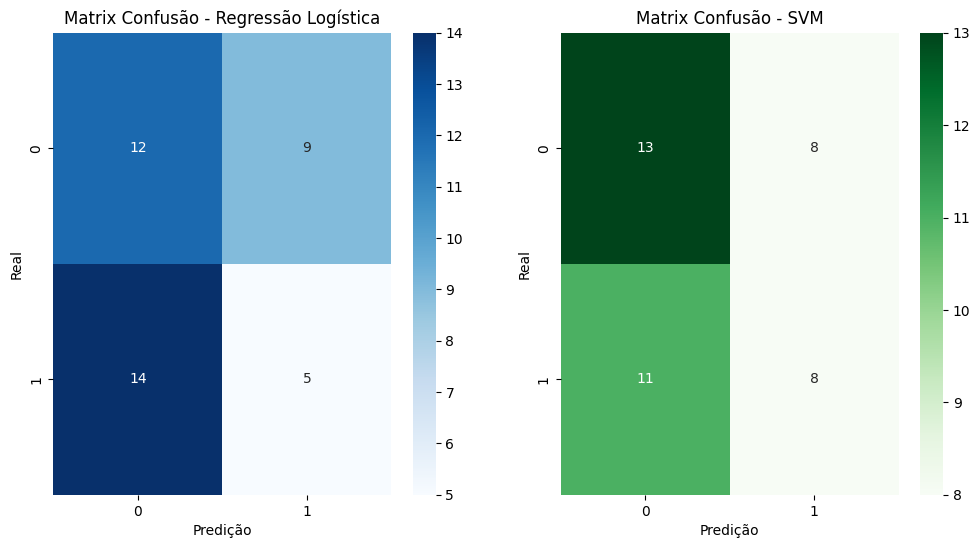

Hyperparameter,Value
logreg__C,10
logreg__penalty,l1
logreg__solver,liblinear
Best Score,0.5625


Hyperparameter,Value
svm__C,1
svm__gamma,scale
svm__kernel,linear
Best Score,0.5437




 Tempo de Treinamento - Regressão Logística: 00:00:25


 Tempo de Treinamento - SVM: 00:00:01
Accuracy for category 'news': 0.35
Accuracy for category 'opinion': 0.48
Accuracy for category 'news': 0.41
Accuracy for category 'opinion': 0.61


In [75]:
############# Carregando token e modelo BERT treinado#########################

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# ############### Preparando Dados ############################################

balanced_df['content'] = balanced_df['content'].apply(preprocess_text)

# Verificando se já existe BERT embeddings

try:
    with open('bert_embeddings.pkl', 'rb') as f:
        balanced_df['embeddings'] = pickle.load(f)
    print("Loaded BERT embeddings from file.")
except FileNotFoundError:
    print("Embeddings file not found, recalculating...")
    balanced_df['embeddings'] = balanced_df['content'].apply(get_bert_embeddings)
    # Gerando BERT embeddings
    with open('bert_embeddings.pkl', 'wb') as f:
        pickle.dump(balanced_df['embeddings'], f)


X_embeddings = np.array(balanced_df['embeddings'].tolist())
# Reshape X_embeddings para  2D
X_embeddings = X_embeddings.reshape(X_embeddings.shape[0], X_embeddings.shape[2])

# Label encode da coluna category
label_encoder = LabelEncoder()
X_category_encoded = label_encoder.fit_transform(balanced_df['category']) # Fit and transform the category column
X_category_encoded = X_category_encoded.reshape(-1, 1) # Reshape to 2D

# Merge embeddings com  encoded category
X = np.concatenate([X_embeddings, X_category_encoded], axis=1)
y = balanced_df['label'].values.ravel()



############### Atualizando os preprocessador e os pipelines####################

# pipelines
pipeline_logreg = Pipeline([
    ('logreg', LogisticRegression(max_iter=500)),
])

pipeline_svm = Pipeline([
    ('svm', SVC()),
])

# Atualizandos os Grids

logreg_param_grid = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga']
}

svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf','poly','sigmoid'],
    'svm__gamma': ['scale', 'auto']
}


######################### Criando os dados de Treinamento e Teste ##############

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



############################## Treinamento #####################################

# Regressão Logistica

logreg_bert_training_time,logreg_bert_best_model, logreg_bert_grid_search= treino(
    'Logistic Regression', pipeline_logreg, logreg_param_grid, X_train, y_train
)

# SVM

svm_bert_training_time,svm_bert_best_model, svm_bert_grid_search = treino(
    'SVM', pipeline_svm, svm_param_grid, X_train, y_train
)


############### Teste #########################################################

logreg_bert_predictions = logreg_bert_best_model.predict(X_test)
svm_bert_predictions = svm_bert_best_model.predict(X_test)


############## Resultado ######################################################

# Geral

avaliacao_e_plot_acuracia(y_test, logreg_bert_predictions, svm_bert_predictions)

# Matriz Confusão

plot_confusion_matrices(y_test, logreg_bert_predictions, svm_bert_predictions)


# Impressão Melhores Hipe-Parametros
display_best_hyperparameters(logreg_bert_grid_search, "Regressão Logística")
display_best_hyperparameters(svm_bert_grid_search, "SVM")

# Tempos de Treinamento

impressao_tempo(logreg_bert_training_time, "Regressão Logística")
impressao_tempo(svm_bert_training_time, "SVM")

# Verificando a acuracia por Categoria

X_test_categories = balanced_df.loc[original_X_test_indices, 'category'].values

# Acurácia por Categoria - Regressão Logística
acuracia_por_categoria(y_test, logreg_bert_predictions, X_test_categories)

# Acurácia por Categoria - SVM
acuracia_por_categoria(y_test, svm_bert_predictions, X_test_categories)

# Word2Vec

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Logistic Regression training time: 2.08 seconds
Fitting 5 folds for each of 18 candidates, totalling 90 fits
SVM training time: 0.39 seconds
Acurácia Logistic Regression (após otimização): 0.4
              precision    recall  f1-score   support

           0       0.42      0.38      0.40        21
           1       0.38      0.42      0.40        19

    accuracy                           0.40        40
   macro avg       0.40      0.40      0.40        40
weighted avg       0.40      0.40      0.40        40



 Acurácia SVM Accuracy (após otimização): 0.475
              precision    recall  f1-score   support

           0       0.50      0.33      0.40        21
           1       0.46      0.63      0.53        19

    accuracy                           0.47        40
   macro avg       0.48      0.48      0.47        40
weighted avg       0.48      0.47      0.46        40



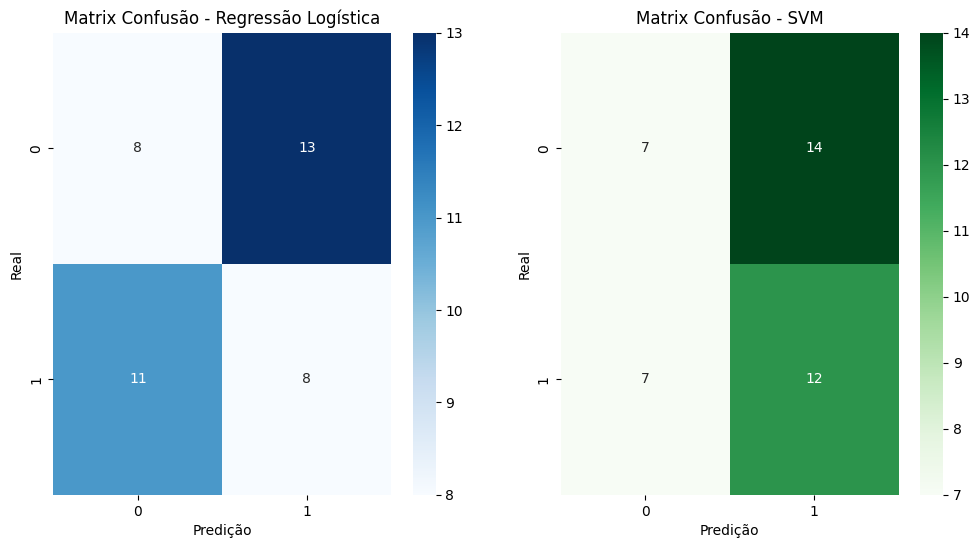

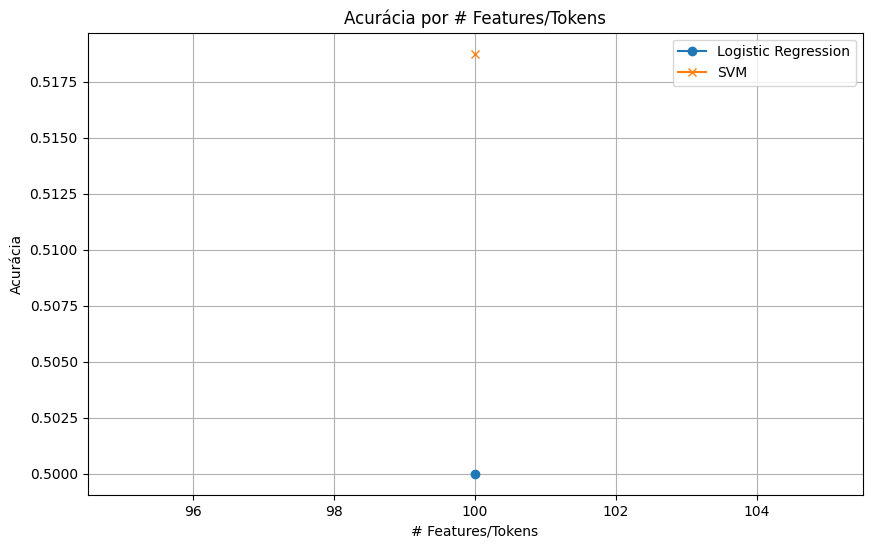

Hyperparameter,Value
logreg__C,0.1
logreg__penalty,l2
logreg__solver,liblinear
Best Score,0.5000


Hyperparameter,Value
svm__C,10
svm__gamma,scale
svm__kernel,poly
Best Score,0.5188




 Tempo de Treinamento - Regressão Logística: 00:00:02


 Tempo de Treinamento - SVM: 00:00:00


In [76]:
#####  Pré Preparação dos Dados ################################################

# Remoção de Features

balanced_df['content'] = balanced_df['content'].apply(preprocess_text)

### Vetorização da coluna content e label encode da coluna categoria

# 1. Prepare data for Word2Vec
sentences = [doc.split() for doc in balanced_df['content']]

# 2. Train Word2Vec model
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=20)

# 3. Get document embeddings (average word vectors)
def get_doc_embedding(doc):
    word_vectors = [model_w2v.wv[word] for word in doc.split() if word in model_w2v.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model_w2v.vector_size)  # Return zero vector for empty documents

X_w2v = balanced_df['content'].apply(get_doc_embedding).to_list()
X_w2v = np.array(X_w2v)

# 4. Label encode the 'category' column
label_encoder = LabelEncoder()
X_category_encoded = label_encoder.fit_transform(balanced_df['category'])
X_category_encoded = X_category_encoded.reshape(-1, 1)  # Reshape to 2D

# 5. Merge embeddings with encoded category
X = np.concatenate([X_w2v, X_category_encoded], axis=1)
y = balanced_df['label'].values.ravel()

# 6. Update pipelines (remove TF-IDF)
pipeline_logreg = Pipeline([
    ('logreg', LogisticRegression(max_iter=500)),
])

pipeline_svm = Pipeline([
    ('svm', SVC()),
])

######################## Criando os dados de Treinamento e Teste ##############

X_train, X_test, y_train, y_test, original_X_train_indices, original_X_test_indices = train_test_split(
     X, y, balanced_df.index, test_size=0.2, random_state=42)



########## Hipeparametros ######################################################
# Regressão Logística
# C = Controle da Regularização : Trade Off entre Bias X Variança e Complexidade do Modelo
# Penalty : L1 (lasso) e  L2 (ridge)
# Solver : Algoritmo a ser usado na otimização (LIBLINEAR ou SAGA). SAGA : Grande Dataset X LIBLINEAR : Otimizador Simples
# Kernel : linear :  Relações mais lineares X  RBF kernel: flexibilidade e relações não lineares.

logreg_param_grid = {
     'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga']
}

svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf','poly'],
    'svm__gamma': ['scale', 'auto']
}


############################## Treinamento #####################################

# Regressão Logistica

logreg_word2vec_training_time,logreg_word2vec_best_model, logreg_word2vec_grid_search= treino(
    'Logistic Regression', pipeline_logreg, logreg_param_grid, X_train, y_train
)

# SVM

svm_word2vec_training_time,svm_word2vec_best_model, svm_word2vec_grid_search = treino(
    'SVM', pipeline_svm, svm_param_grid, X_train, y_train
)



############### Teste #########################################################

logreg_word2vec_predictions = logreg_word2vec_best_model.predict(X_test)
svm_word2vec_predictions = svm_word2vec_best_model.predict(X_test)


############## Resultado ######################################################

# Geral

avaliacao_e_plot_acuracia(y_test, logreg_word2vec_predictions, svm_word2vec_predictions)

# Matriz Confusão

plot_confusion_matrices(y_test, logreg_word2vec_predictions, svm_word2vec_predictions)

# Acurácia X Max Features
logreg_word2vec_grid_search_results = logreg_word2vec_grid_search.cv_results_
svm_word2vec_grid_search_results = svm_word2vec_grid_search.cv_results_
plot_acuracia_por_max_features(logreg_word2vec_grid_search, svm_word2vec_grid_search)


# Impressão Melhores Hipe-Parametros
display_best_hyperparameters(logreg_word2vec_grid_search, "Regressão Logística")
display_best_hyperparameters(svm_word2vec_grid_search, "SVM")


# Tempos de Treinamento

impressao_tempo(logreg_word2vec_training_time, "Regressão Logística")
impressao_tempo(svm_word2vec_training_time, "SVM")



# Resultados Gerais

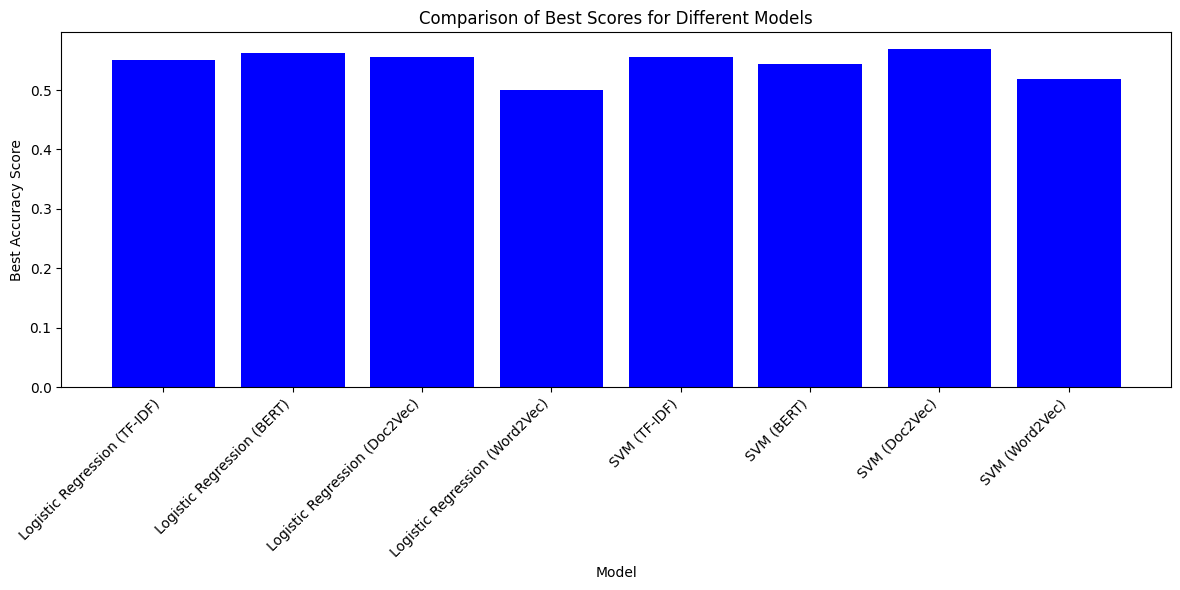

In [77]:
# Create a list of all the grid search results
grid_search_results = [
    logreg_grid_search,  # Use the GridSearchCV object
    logreg_bert_grid_search,  # Use the GridSearchCV object
    logreg_doc2vec_grid_search,  # Use the GridSearchCV object
    logreg_word2vec_grid_search,  # Use the GridSearchCV object
    svm_grid_search,  # Use the GridSearchCV object
    svm_bert_grid_search,  # Use the GridSearchCV object
    svm_doc2vec_grid_search,  # Use the GridSearchCV object
    svm_word2vec_grid_search,  # Use the GridSearchCV object
]

# Create a list of labels for the different models
model_labels = [
    "Logistic Regression (TF-IDF)",
    "Logistic Regression (BERT)",
    "Logistic Regression (Doc2Vec)",
    "Logistic Regression (Word2Vec)",
    "SVM (TF-IDF)",
    "SVM (BERT)",
    "SVM (Doc2Vec)",
    "SVM (Word2Vec)",
]

# Create a list of the best scores achieved by each model
best_scores = [results.best_score_ for results in grid_search_results]

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(model_labels, best_scores, color='blue')
plt.xlabel("Model")
plt.ylabel("Best Accuracy Score")
plt.title("Comparison of Best Scores for Different Models")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
def create_stock_prediction_model(max_content_length, embedding_dim, hidden_dim, num_categories):
    """
    Creates a model for stock price prediction using content and category.

    Args:
        max_content_length: Maximum length of the content text.
        embedding_dim: Dimension of the word embeddings.
        hidden_dim: Dimension of the hidden state of the LSTM.
        num_categories: Number of categories.

    Returns:
        A Keras Model object.
    """

    # 1. Content Input and BERT Encoding
    content_input = Input(shape=(max_content_length,), name='content_input')
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    bert_embeddings = bert_model(bert_tokenizer(content_input, return_tensors='tf', padding=True, truncation=True))['last_hidden_state']
    content_encoding = bert_embeddings[:, 0, :]  # Use [CLS] token embedding

    # 2. Category Input and Embedding
    category_input = Input(shape=(1,), name='category_input')
    category_embedding_layer = Embedding(num_categories, embedding_dim)
    category_embedding = category_embedding_layer(category_input)
    category_embedding = tf.squeeze(category_embedding, axis=1)  # Remove extra dimension

    # 3. Concatenate Encodings
    merged_input = Concatenate()([content_encoding, category_embedding])

    # 4. Dense Layers for Prediction
    hidden_layer = Dense(hidden_dim, activation='relu')(merged_input)
    output_layer = Dense(1, activation='sigmoid', name='label_output')(hidden_layer)

    # 5. Define the Model
    model = Model(inputs=[content_input, category_input], outputs=output_layer)
    return model


In [ ]:
def create_model(max_content_length=512, embedding_dim=128, hidden_dim=256):
    model = create_stock_prediction_model(max_content_length, embedding_dim, hidden_dim)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:
# 2. Define the hyperparameter grid
param_grid = {
    'max_content_length': [256, 512],
    'embedding_dim': [64, 128],
    'hidden_dim': [128, 256],
    'epochs': [5, 10],
    'batch_size': [32, 64]
}

# 3. Create GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')  # cv=3 for 3-fold cross-validation

# 4. Fit the grid search to your data
grid_result = grid.fit([X_content_train, X_category_train], y_train)

# 5. Print the best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# 6. Get the best model
best_model = grid_result.best_estimator_.model

# 7. Evaluate the best model on the test set
_, test_accuracy = best_model.evaluate([X_content_test, X_category_test], y_test, verbose=0)
print(f"Test Accuracy of Best Model: {test_accuracy:.4f}")

# 8. Make predictions using the best model
predictions = best_model.predict([X_content_new, X_category_new])

# 9. Further analysis of predictions
from sklearn.metrics import classification_report, confusion_matrix

# a. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, (predictions > 0.5).astype(int)))  # Convert probabilities to 0/1

# b. Confusion Matrix
cm = confusion_matrix(y_test, (predictions > 0.5).astype(int))
print("\nConfusion Matrix:")
print(cm)

# c. Visualize Confusion Matrix (optional)
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()